<img src="http://developer.download.nvidia.com/notebooks/dlsw-notebooks/tensorrt_torchtrt_efficientnet/nvidia_logo.png" width="90px">

# Pyspark TensorFlow Inference

## Image classification
This notebook demonstrates training and distributed inference for image classification on MNIST.  
Based on: https://www.tensorflow.org/tutorials/keras/save_and_load

Note that cuFFT/cuDNN/cuBLAS registration errors are expected (as of `tf=2.17.0`) and will not affect behavior, as noted in [this issue.](https://github.com/tensorflow/tensorflow/issues/62075)  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import shutil
import os

import tensorflow as tf
from tensorflow import keras

2025-02-04 13:58:23.275397: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-04 13:58:23.282713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-04 13:58:23.290717: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-04 13:58:23.293187: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 13:58:23.299616: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.version.VERSION)

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2.17.0


I0000 00:00:1738706304.084788 3671509 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738706304.107153 3671509 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738706304.109954 3671509 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


### Load and preprocess dataset

Load MNIST and create a train/test split.

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
train_labels = train_labels[:1000]
test_labels = test_labels[:1000]

train_images = train_images[:1000].reshape(-1, 28 * 28) / 255.0
test_images = test_images[:1000].reshape(-1, 28 * 28) / 255.0

train_images.shape, test_images.shape

((1000, 784), (1000, 784))

### Define a model

In [5]:
# Define a simple sequential model
def create_model():
    model = tf.keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10)
    ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

/home/rishic/anaconda3/envs/spark-dl-tf/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1738706304.278396 3671509 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


I0000 00:00:1738706304.281131 3671509 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738706304.283741 3671509 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738706304.403175 3671509 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738706304.404296 3671509 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,050 (1.55 MB)

 Trainable params: 407,050 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

### Save checkpoints during training

In [6]:
os.mkdir("models") if not os.path.exists("models") else None

In [7]:
checkpoint_path = "models/training_1/checkpoint.model.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_sparse_categorical_accuracy',
                                                 mode='max',
                                                 save_best_only=True,
                                                 verbose=1)

# Train the model with the new callback
model.fit(train_images, 
          train_labels,  
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

Epoch 1/10


I0000 00:00:1738706304.982690 3671754 service.cc:146] XLA service 0x7f1464019260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738706304.982718 3671754 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-02-04 13:58:24.999594: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-04 13:58:25.043847: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 1/32 ━━━━━━━━━━━━━━━━━━━━ 26s 868ms/step - loss: 2.4638 - sparse_categorical_accuracy: 0.0625

I0000 00:00:1738706305.619913 3671754 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6323 - sparse_categorical_accuracy: 0.4913  

2025-02-04 13:58:26.791107: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 4 bytes spill stores, 4 bytes spill loads




Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.76100, saving model to models/training_1/checkpoint.model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 1.6179 - sparse_categorical_accuracy: 0.4965 - val_loss: 0.7533 - val_sparse_categorical_accuracy: 0.7610
Epoch 2/10
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3965 - sparse_categorical_accuracy: 0.9062
Epoch 2: val_sparse_categorical_accuracy improved from 0.76100 to 0.80400, saving model to models/training_1/checkpoint.model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4549 - sparse_categorical_accuracy: 0.8773 - val_loss: 0.6002 - val_sparse_categorical_accuracy: 0.8040
Epoch 3/10
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4427 - sparse_categorical_accuracy: 0.8438
Epoch 3: val_sparse_categorical_accuracy improved from 0.80400 to 0.85100, saving model to models/training_1/checkpoint.model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2924 - sparse_categorical_accuracy: 0.9289

In [8]:
os.listdir(checkpoint_dir)

['checkpoint.model.keras']

In [ ]:
# Export model in saved_model format
model.export("models/mnist_model")

INFO:tensorflow:Assets written to: models/mnist_model/assets


INFO:tensorflow:Assets written to: models/mnist_model/assets


Saved artifact at 'models/mnist_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139734758151120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139734413261904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139739081696528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139734413262096: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [10]:
# Create a basic model instance
model = create_model()

# Evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

/home/rishic/anaconda3/envs/spark-dl-tf/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 - 0s - 10ms/step - loss: 2.3876 - sparse_categorical_accuracy: 0.0840
Untrained model, accuracy:  8.40%


In [ ]:
# Load the weights from the checkpoint
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 0s - 704us/step - loss: 0.4062 - sparse_categorical_accuracy: 0.8690
Restored model, accuracy: 86.90%


/home/rishic/anaconda3/envs/spark-dl-tf/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Checkpoint callback options

In [12]:
os.mkdir("models/training_2") if not os.path.exists("models/training_2") else None

In [13]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "models/training_2/cp-{epoch:04d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Calculate the number of batches per epoch
import math
n_batches = len(train_images) / batch_size
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*n_batches)

# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model.fit(train_images, 
          train_labels,
          epochs=50, 
          batch_size=batch_size, 
          callbacks=[cp_callback],
          validation_data=(test_images, test_labels),
          verbose=0)


Epoch 5: saving model to models/training_2/cp-0005.weights.h5

Epoch 10: saving model to models/training_2/cp-0010.weights.h5

Epoch 15: saving model to models/training_2/cp-0015.weights.h5

Epoch 20: saving model to models/training_2/cp-0020.weights.h5

Epoch 25: saving model to models/training_2/cp-0025.weights.h5

Epoch 30: saving model to models/training_2/cp-0030.weights.h5

Epoch 35: saving model to models/training_2/cp-0035.weights.h5

Epoch 40: saving model to models/training_2/cp-0040.weights.h5

Epoch 45: saving model to models/training_2/cp-0045.weights.h5

Epoch 50: saving model to models/training_2/cp-0050.weights.h5


In [14]:
os.listdir(checkpoint_dir)

['cp-0000.weights.h5',
 'cp-0015.weights.h5',
 'cp-0010.weights.h5',
 'cp-0035.weights.h5',
 'cp-0020.weights.h5',
 'cp-0040.weights.h5',
 'cp-0050.weights.h5',
 'cp-0005.weights.h5',
 'cp-0045.weights.h5',
 'cp-0025.weights.h5',
 'cp-0030.weights.h5']

In [15]:
latest = "models/training_2/cp-0030.weights.h5"

In [16]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

# Re-evaluate the model from the latest checkpoint
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 0s - 11ms/step - loss: 0.4827 - sparse_categorical_accuracy: 0.8740
Restored model, accuracy: 87.40%


## PySpark

In [17]:
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col, array, pandas_udf
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark import SparkConf
import pandas as pd
import json

Check the cluster environment to handle any platform-specific Spark configurations.

In [18]:
on_databricks = os.environ.get("DATABRICKS_RUNTIME_VERSION", False)
on_dataproc = os.environ.get("DATAPROC_IMAGE_VERSION", False)
on_standalone = not (on_databricks or on_dataproc)

#### Create Spark Session

For local standalone clusters, we'll connect to the cluster and create the Spark Session.  
For CSP environments, Spark will either be preconfigured (Databricks) or we'll need to create the Spark Session (Dataproc).

In [19]:
conf = SparkConf()

if 'spark' not in globals():
    if on_standalone:
        import socket
        
        conda_env = os.environ.get("CONDA_PREFIX")
        hostname = socket.gethostname()
        conf.setMaster(f"spark://{hostname}:7077")
        conf.set("spark.pyspark.python", f"{conda_env}/bin/python")
        conf.set("spark.pyspark.driver.python", f"{conda_env}/bin/python")
    elif on_dataproc:
        conf.set("spark.executorEnv.TF_GPU_ALLOCATOR", "cuda_malloc_async")

    conf.set("spark.executor.cores", "8")
    conf.set("spark.task.resource.gpu.amount", "0.125")
    conf.set("spark.executor.resource.gpu.amount", "1")
    conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
    conf.set("spark.python.worker.reuse", "true")

conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1000")
spark = SparkSession.builder.appName("spark-dl-examples").config(conf=conf).getOrCreate()
sc = spark.sparkContext

25/02/04 13:58:33 WARN Utils: Your hostname, cb4ae00-lcedt resolves to a loopback address: 127.0.1.1; using 10.110.47.100 instead (on interface eno1)
25/02/04 13:58:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/04 13:58:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Create Spark Dataframe

In [20]:
# numpy array to pandas DataFrame
test_pdf = pd.DataFrame(test_images)
test_pdf.shape

(1000, 784)

In [21]:
df = spark.createDataFrame(test_pdf).repartition(8)

### Save as Parquet (784 columns of float)

In [22]:
%%time
data_path_784 = "spark-dl-datasets/mnist_784"
if on_databricks:
    dbutils.fs.mkdirs("/FileStore/spark-dl-datasets")
    data_path_784 = "dbfs:/FileStore/" + data_path_784

df.write.mode("overwrite").parquet(data_path_784)

25/02/04 13:58:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


CPU times: user 3.05 ms, sys: 1.22 ms, total: 4.26 ms
Wall time: 1.93 s


### Save as Parquet (1 column of 784 float)

In [23]:
test_pdf['data'] = test_pdf.values.tolist()
pdf = test_pdf[['data']]
pdf.shape

(1000, 1)

In [24]:
df = spark.createDataFrame(pdf)

In [25]:
%%time
data_path_1 = "spark-dl-datasets/mnist_1"
if on_databricks:
    dbutils.fs.mkdirs("/FileStore/spark-dl-datasets")
    data_path_1 = "dbfs:/FileStore/" + data_path_1

df.write.mode("overwrite").parquet(data_path_1)

CPU times: user 875 μs, sys: 187 μs, total: 1.06 ms
Wall time: 196 ms


## Inference using Spark DL API

Distributed inference using the PySpark [predict_batch_udf](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.functions.predict_batch_udf.html#pyspark.ml.functions.predict_batch_udf):

- predict_batch_fn uses Tensorflow APIs to load the model and return a predict function which operates on numpy arrays 
- predict_batch_udf will convert the Spark DataFrame columns into numpy input batches for the predict function

### 1 column of 784 float

In [26]:
model_path = "{}/models/training_1/checkpoint.model.keras".format(os.getcwd())

# For cloud environments, copy the model to the distributed file system.
if on_databricks:
    dbutils.fs.mkdirs("/FileStore/spark-dl-models")
    dbfs_model_path = "/dbfs/FileStore/spark-dl-models/checkpoint.model.keras"
    shutil.copy(model_path, dbfs_model_path)
    model_path = dbfs_model_path
elif on_dataproc:
    # GCS is mounted at /mnt/gcs by the init script
    models_dir = "/mnt/gcs/spark-dl/models"
    os.mkdir(models_dir) if not os.path.exists(models_dir) else None
    gcs_model_path = models_dir + "/checkpoint.model.keras"
    shutil.copy(model_path, gcs_model_path)
    model_path = gcs_model_path

In [27]:
def predict_batch_fn():
    import tensorflow as tf

    # Enable GPU memory growth to avoid CUDA OOM
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    model = tf.keras.models.load_model(model_path)
    def predict(inputs: np.ndarray) -> np.ndarray:
        return model.predict(inputs)
        
    return predict

In [28]:
mnist = predict_batch_udf(predict_batch_fn,
                          return_type=ArrayType(FloatType()),
                          batch_size=128,
                          input_tensor_shapes=[[784]])

In [29]:
df = spark.read.parquet(data_path_1)
len(df.columns)

1

In [30]:
df.show(5)

+--------------------+
|                data|
+--------------------+
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
+--------------------+
only showing top 5 rows



In [31]:
%%time
# first pass caches model/fn
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 24.1 ms, sys: 11 ms, total: 35.2 ms
Wall time: 5.52 s


In [32]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 21.1 ms, sys: 14.7 ms, total: 35.8 ms
Wall time: 277 ms


In [33]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 37.1 ms, sys: 8.46 ms, total: 45.6 ms
Wall time: 216 ms


#### Check predictions

In [34]:
preds = df.withColumn("preds", mnist(*df.columns)).limit(10).toPandas()
preds

,data,preds
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.6654954, -2.4895542, -0.5886033, 13.380537..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.273215, -7.5127845, 1.1983701, -3.540661, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.28909, 0.8308607, 0.31311005, 1.1683632, -..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.0551968, -6.5028114, 12.420729, 0.45280308..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.7887802, 3.9983602, -1.5343361, -0.3698440..."
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.499274, -1.7618222, 1.1183227, 3.946932, -..."
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.7540536, 4.8684144, 0.25152916, -0.4730078..."
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.8887109, 0.02717152, -6.0508857, 0.0875094..."
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9541265, -2.113048, -1.7508972, -5.4303794,..."
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.612412, -0.7655784, -4.473859, 2.0609212, ..."


In [35]:
sample = preds.iloc[0]
sample.preds

array([-4.6654954, -2.4895542, -0.5886033, 13.380537 , -6.652599 ,
        2.8400383, -7.9901567, -0.7500452, -2.4487166, -4.349809 ],
      dtype=float32)

In [36]:
import matplotlib.pyplot as plt
import numpy as np

In [37]:
prediction = np.argmax(sample.preds)
img = np.array(sample.data).reshape(28,28)

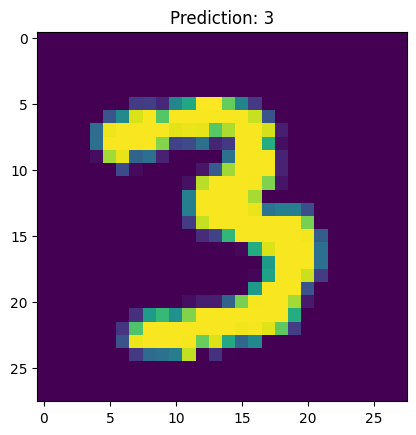

In [ ]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()

### 784 columns of float

In [39]:
def predict_batch_fn():
    import tensorflow as tf
    # Enable GPU memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
            
    model = tf.keras.models.load_model(model_path)
    def predict(inputs: np.ndarray) -> np.ndarray:
        return model.predict(inputs)
        
    return predict

In [40]:
mnist = predict_batch_udf(predict_batch_fn,
                          return_type=ArrayType(FloatType()),
                          batch_size=128,
                          input_tensor_shapes=[[784]])

In [ ]:
df = spark.read.parquet(data_path_784)
len(df.columns)

784

In [42]:
%%time
preds = df.withColumn("preds", mnist(struct(*df.columns))).collect()

CPU times: user 52.5 ms, sys: 22 ms, total: 74.5 ms
Wall time: 5.72 s


In [43]:
%%time
preds = df.withColumn("preds", mnist(array(*df.columns))).collect()

CPU times: user 49.4 ms, sys: 31.9 ms, total: 81.2 ms
Wall time: 1.34 s


In [44]:
# should raise ValueError
# preds = df.withColumn("preds", mnist(*df.columns)).collect()

### Check prediction

In [45]:
preds = df.withColumn("preds", mnist(struct(df.columns))).limit(10).toPandas()
preds

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,preds
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-6.9618006, 1.2047814, -0.09570807, 0.0462105..."
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-5.2882323, 5.902014, -2.0389183, -1.2460864,..."
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-5.822013, -2.3333628, -2.4322102, -8.040086,..."
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-0.57203317, -1.2920653, -2.7234774, 0.914070..."
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-3.689301, 5.0702505, -0.23930073, -0.7988689..."
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[8.268821, -2.070008, 1.722378, -1.8471404, -8..."
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[5.59269, -3.1613479, 0.4734843, -0.7772096, -..."
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.9852623, -5.166985, 0.86473066, -6.491789, ..."
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-2.800528, -4.2984514, 10.887824, -3.1346364,..."
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-3.7827752, -4.51145, -5.354035, 9.399383, -6..."


In [46]:
import matplotlib.pyplot as plt
import numpy as np

In [47]:
sample = preds.iloc[0]
sample.preds

array([-6.9618006 ,  1.2047814 , -0.09570807,  0.04621054, -5.8169513 ,
       -4.148872  , -5.17938   ,  6.382909  , -0.11228667,  0.6022302 ],
      dtype=float32)

In [48]:
prediction = np.argmax(sample.preds)
img = sample.drop('preds').to_numpy(dtype=float)
img = np.array(img).reshape(28,28)

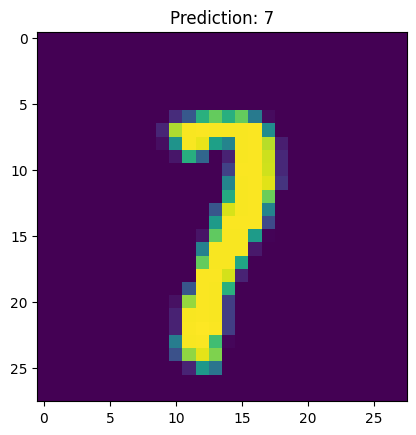

In [ ]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()

## Using Triton Inference Server
In this section, we demonstrate integration with the [Triton Inference Server](https://developer.nvidia.com/nvidia-triton-inference-server), an open-source, GPU-accelerated serving solution for DL.  
We use [PyTriton](https://github.com/triton-inference-server/pytriton), a Flask-like framework that handles client/server communication with the Triton server.  

The process looks like this:
- Distribute a PyTriton task across the Spark cluster, instructing each node to launch a Triton server process.
- Define a Triton inference function, which contains a client that binds to the local server on a given node and sends inference requests.
- Wrap the Triton inference function in a predict_batch_udf to launch parallel inference requests using Spark.
- Finally, distribute a shutdown signal to terminate the Triton server processes on each node.

<img src="../images/spark-server.png" alt="drawing" width="700"/>

In [50]:
from functools import partial

Import the helper class from server_utils.py:

In [51]:
sc.addPyFile("server_utils.py")

from server_utils import TritonServerManager

Define the Triton Server function:

In [52]:
def triton_server(ports, model_path):
    import time
    import signal
    import numpy as np
    from pytriton.decorators import batch
    from pytriton.model_config import DynamicBatcher, ModelConfig, Tensor
    from pytriton.triton import Triton, TritonConfig
    from pyspark import TaskContext
    import tensorflow as tf
    from tensorflow import keras

    print(f"SERVER: Initializing model on worker {TaskContext.get().partitionId()}.")

    # Enable GPU memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    model = keras.models.load_model(model_path)

    @batch
    def _infer_fn(**inputs):
        images = np.squeeze(inputs["images"])
        print(f"SERVER: Received batch of size {len(images)}.")
        return {
            "labels": model.predict(images)
        }

    workspace_path = f"/tmp/triton_{time.strftime('%m_%d_%M_%S')}"
    triton_conf = TritonConfig(http_port=ports[0], grpc_port=ports[1], metrics_port=ports[2])
    with Triton(config=triton_conf, workspace=workspace_path) as triton:
        triton.bind(
            model_name="ImageClassifier",
            infer_func=_infer_fn,
            inputs=[
                Tensor(name="images", dtype=np.float64, shape=(-1,)),
            ],
            outputs=[
                Tensor(name="labels", dtype=np.float32, shape=(-1,)),
            ],
            config=ModelConfig(
                max_batch_size=128,
                batcher=DynamicBatcher(max_queue_delay_microseconds=5000),  # 5ms
            ),
            strict=True,
        )

        def _stop_triton(signum, frame):
            # The server manager sends SIGTERM to stop the server; this function ensures graceful cleanup.
            print("SERVER: Received SIGTERM. Stopping Triton server.")
            triton.stop()

        signal.signal(signal.SIGTERM, _stop_triton)

        print("SERVER: Serving inference")
        triton.serve()

#### Start Triton servers

The `TritonServerManager` will handle the lifecycle of Triton server instances across the Spark cluster:
- Find available ports for HTTP/gRPC/metrics
- Deploy a server on each node via stage-level scheduling
- Gracefully shutdown servers across nodes

In [ ]:
model_name = "ImageClassifier"
server_manager = TritonServerManager(model_name=model_name, model_path=model_path)

In [ ]:
# Returns {'hostname', (server_pid, [http_port, grpc_port, metrics_port])}
server_manager.start_servers(triton_server)

2025-02-07 11:03:44,809 - INFO - Requesting stage-level resources: (cores=5, gpu=1.0)
2025-02-07 11:03:44,810 - INFO - Starting 1 servers.


{'cb4ae00-lcedt': (2020631, [7000, 7001, 7002])}

#### Define client function

Get the hostname -> url mapping from the server manager:

In [ ]:
host_to_http_url = server_manager.host_to_http_url  # or server_manager.host_to_grpc_url

Define the Triton inference function, which returns a predict function for batch inference through the server:

In [57]:
def triton_fn(model_name, host_to_url):
    import socket
    from pytriton.client import ModelClient

    url = host_to_url[socket.gethostname()]
    print(f"Connecting to Triton model {model_name} at {url}.")

    def infer_batch(inputs):
        with ModelClient(url, model_name, inference_timeout_s=240) as client:
            result_data = client.infer_batch(inputs)
            return result_data["labels"]
        
    return infer_batch

In [59]:
predict = predict_batch_udf(partial(triton_fn, model_name=model_name, host_to_url=host_to_http_url),
                            input_tensor_shapes=[[784]],
                            return_type=ArrayType(FloatType()),
                            batch_size=128)

#### Run inference

In [58]:
df = spark.read.parquet(data_path_1)
df.schema

StructType([StructField('data', ArrayType(DoubleType(), True), True)])

In [60]:
%%time
preds = df.withColumn("preds", predict(struct("data"))).collect()

CPU times: user 19.8 ms, sys: 2.89 ms, total: 22.7 ms
Wall time: 1.67 s


In [61]:
%%time
preds = df.withColumn("preds", predict("data")).collect()

CPU times: user 19.8 ms, sys: 5.99 ms, total: 25.7 ms
Wall time: 399 ms


In [62]:
%%time
preds = df.withColumn("preds", predict(col("data"))).limit(10).toPandas()
preds

CPU times: user 9.07 ms, sys: 1.34 ms, total: 10.4 ms
Wall time: 888 ms


,data,preds
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.6654444, -2.4893682, -0.5888205, 13.380681..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.2732146, -7.5127845, 1.1983705, -3.540661,..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.2890894, 0.8308606, 0.31311002, 1.1683631,..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.055197, -6.502811, 12.420727, 0.4528031, -..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.7887795, 3.9983597, -1.5343359, -0.3698441..."
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.4992743, -1.7618219, 1.1183226, 3.9469318,..."
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.754053, 4.868414, 0.2515293, -0.47300792, ..."
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.888711, 0.02717158, -6.050885, 0.08750934,..."
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.9541264, -2.113048, -1.7508973, -5.4303784,..."
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.612412, -0.7655782, -4.473859, 2.0609212, ..."


In [63]:
import matplotlib.pyplot as plt
import numpy as np

In [64]:
sample = preds.iloc[0]
sample.preds

prediction = np.argmax(sample.preds)
img = np.array(sample.data).reshape(28,28)

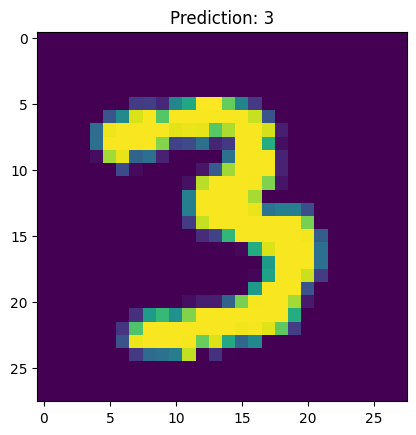

In [65]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()

#### Stop Triton Server on each executor

In [ ]:
server_manager.stop_servers()

2025-02-04 14:00:18,330 - INFO - Requesting stage-level resources: (cores=5, gpu=1.0)
2025-02-04 14:00:28,520 - INFO - Sucessfully stopped 1 servers.                 


[True]

In [67]:
if not on_databricks: # on databricks, spark.stop() puts the cluster in a bad state
    spark.stop()